# Test the original WWZ from libwwz (bar manually set frequency steps)

In [610]:
%load_ext autoreload
%autoreload 2
import cython
import wwz_edited
import plot_methods_edited
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import matplotlib.axes as axes
import matplotlib.colors as colors
from datetime import datetime


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.0
largest tau window is  27.667
3.71 seconds has passed to complete Weighted Wavelet Z-transform 



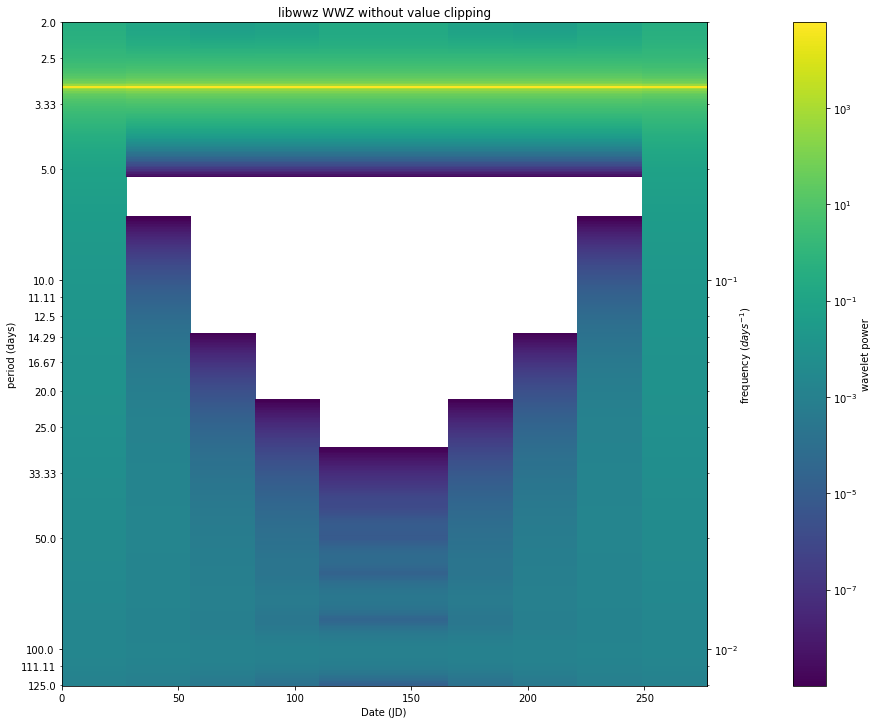

In [883]:
# generate data for a sine wave observed for 10 years with random noise added
# data = np.loadtxt(data_path+"ogle_merged/sxp327.csv", delimiter=",", dtype=float)
x = np.linspace(0, 249, num=250)
period = 3
f=1/period
y = np.sin(x*f*np.pi*2)#+np.random.normal(0,0.5,size=len(x))


# Select the size for the newly generated timestamps (tau), it should be less than the length of the given data.
# This will also limit the minimum possible frequecny
ntau = 10 #(x[-1]-x[0])/4 # no. linear divisions between first and last time stamps of the time series

# Set the low and high frequency bounds and steps to iterate 
frequency_low = 1/125
frequency_high = 1/2
# frequency_steps = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=1000)
# frequency_steps = frequency_steps[1]-frequency_steps[0]

# Set the override to False (Setting to True will ignore the low and high frequency limitations)
override = False

# gather the frequency parameters into a list [freq_low, freq_high, freq_step, override]
frequency_parameters = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=400)#[frequency_low, frequency_high, frequency_steps, override]

# We will then select the decay constant for our analyzing wavelet (should be < 0.2), where c = 1/(2*w^2) 
# The analyzing wavelet decays significantly in a single cycle 2*pi/w, where w = 2*pi*f

# f = 20     # we choose 4 since our signal of interest is at 4 h
# w = 2 * np.pi * f
# decay_constant = 1/(2*w**2)
decay_constant = 1/(8*np.pi**2)
# Finally, we select to wether to run with parallization (recommend True)
parallel = True


# Using the above settings, we will now compute the WWZ/WWA for the full timeseries and removed timeseries
wwt_spec_Nyq = wwz_edited.wwt(timestamps=x,
                     magnitudes=y,
                     time_divisions=ntau,
                     freq_params=frequency_parameters,
                     decay_constant=decay_constant, parallel=True)

fig, ax = plt.subplots(nrows=1, sharex=False, figsize=[13, 10])
plot_methods_edited.log_plotter(ax=ax,
                       TAU=wwt_spec_Nyq[0],
                       FREQ=wwt_spec_Nyq[1],
                       DATA=wwt_spec_Nyq[2],
                    clip=None)#(np.percentile(wwt_spec_Nyq[2], 75),np.percentile(wwt_spec_Nyq[2], 99.9)))
fig.tight_layout()
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
plt.title("libwwz WWZ without value clipping")
# plt.savefig('test_images/test_spectrogram_{}.png'.format(dt_string))
plt.show()

In [ ]:
plt.plot(1/wwt_spec_Nyq[1][0], np.mean(np.abs(wwt_spec_Nyq[2])**2, axis=0), c="black", zorder=2)
plt.xlabel("period")
plt.ylabel("mean of squared wavelet z-transform")
plt.title("weighted wavelet z-transform")
plt.axvline(x=period, c="orange", zorder=1)
plt.show()

plt.plot(1/wwt_spec_Nyq[1][0], np.mean(np.abs(wwt_spec_Nyq[3])**2, axis=0), c="black", zorder=2)
plt.xlabel("period")
plt.ylabel("mean of squared weighted wavelet amplitude")
plt.title("weighted wavelet amplitude")
plt.axvline(x=period, c="orange", zorder=1)
plt.show()

# idat loop removed

In [905]:
%load_ext autoreload
%autoreload 2
import cython
import wwzp
import plot_methods_edited
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import matplotlib.axes as axes
import matplotlib.colors as colors
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.0
largest tau window is  277.667
6.72 seconds has passed to complete Weighted Wavelet Z-transform 



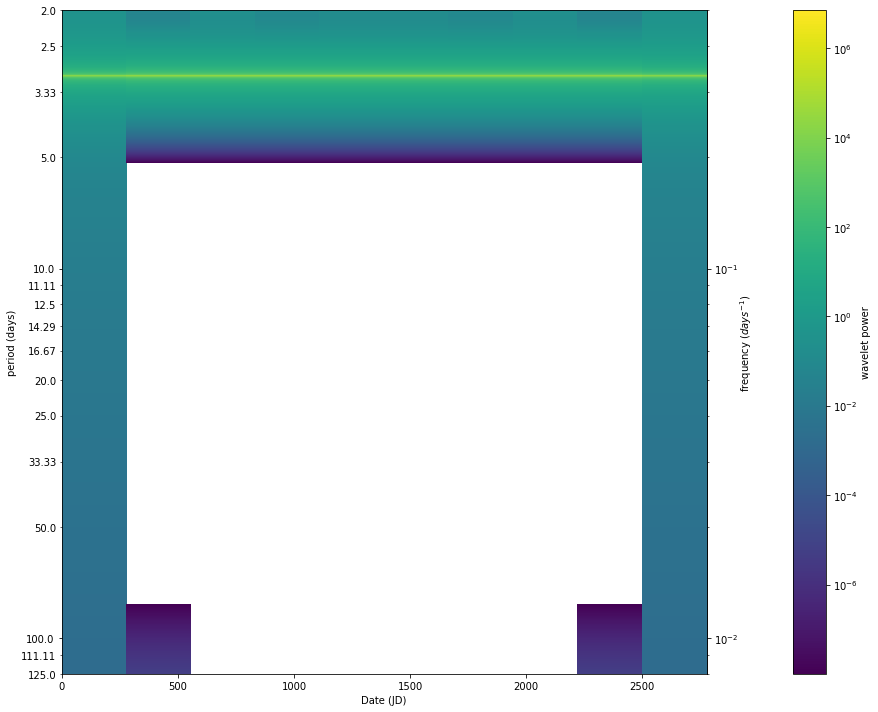

In [907]:
# generate data for a sine wave observed for 10 years with random noise added
# data = np.loadtxt(data_path+"ogle_merged/sxp327.csv", delimiter=",", dtype=float)
x = np.linspace(0, 2499, num=2500)
period = 3
f=1/period
y = np.sin(x*f*np.pi*2)#+np.random.normal(0,0.5,size=len(x))


# Select the size for the newly generated timestamps (tau), it should be less than the length of the given data.
# This will also limit the minimum possible frequecny
ntau = 10 #(x[-1]-x[0])/4 # no. linear divisions between first and last time stamps of the time series

# Set the low and high frequency bounds and steps to iterate 
frequency_low = 1/125
frequency_high = 1/2
# frequency_steps = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=1000)
# frequency_steps = frequency_steps[1]-frequency_steps[0]

# Set the override to False (Setting to True will ignore the low and high frequency limitations)
override = False

# gather the frequency parameters into a list [freq_low, freq_high, freq_step, override]
frequency_parameters = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=4000)#[frequency_low, frequency_high, frequency_steps, override]

# We will then select the decay constant for our analyzing wavelet (should be < 0.2), where c = 1/(2*w^2) 
# The analyzing wavelet decays significantly in a single cycle 2*pi/w, where w = 2*pi*f

# f = 20     # we choose 4 since our signal of interest is at 4 h
# w = 2 * np.pi * f
# decay_constant = 1/(2*w**2)
decay_constant = 1/(8*np.pi**2)
# Finally, we select to wether to run with parallization (recommend True)
parallel = True

# Using the above settings, we will now compute the WWZ/WWA for the full timeseries and removed timeseries
wwt_p = wwzp.wwt(timestamps=x,
                     magnitudes=y,
                     time_divisions=ntau,
                     freq_params=frequency_parameters,
                     decay_constant=decay_constant, parallel=True)

fig, ax = plt.subplots(nrows=1, sharex=False, figsize=[13, 10])
plot_methods_edited.log_plotter(ax=ax,
                       TAU=wwt_p[0],
                       FREQ=wwt_p[1],
                       DATA=wwt_p[2],
                    clip=None)#(np.percentile(wwt_p[2], 75),np.percentile(wwt_p[2], 99.9)))
fig.tight_layout()
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
# plt.title("vectorized WWZ without value clipping")
# plt.savefig('test_images/test_spectrogram_{}.png'.format(dt_string))
plt.show()

In [891]:
freq = frequency_parameters
tau = np.linspace(x[0], x[-1], 10)

np.tile(tau,(len(freq),1)).T

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 27.66666667,  27.66666667,  27.66666667, ...,  27.66666667,
         27.66666667,  27.66666667],
       [ 55.33333333,  55.33333333,  55.33333333, ...,  55.33333333,
         55.33333333,  55.33333333],
       ...,
       [193.66666667, 193.66666667, 193.66666667, ..., 193.66666667,
        193.66666667, 193.66666667],
       [221.33333333, 221.33333333, 221.33333333, ..., 221.33333333,
        221.33333333, 221.33333333],
       [249.        , 249.        , 249.        , ..., 249.        ,
        249.        , 249.        ]])

In [898]:
np.mean(np.tile(tau,(len(freq),1)).T == wwt_spec_Nyq[0])

1.0

In [899]:
np.mean(np.tile(freq, (len(tau),1)) == wwt_spec_Nyq[1])

1.0

In [880]:
np.tile(np.array((1,2)),(5,1)).T == 

array([[1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2]])

In [894]:
wwt_spec_Nyq[1]#.shape

array([[0.008     , 0.00808334, 0.00816755, ..., 0.48974284, 0.49484485,
        0.5       ],
       [0.008     , 0.00808334, 0.00816755, ..., 0.48974284, 0.49484485,
        0.5       ],
       [0.008     , 0.00808334, 0.00816755, ..., 0.48974284, 0.49484485,
        0.5       ],
       ...,
       [0.008     , 0.00808334, 0.00816755, ..., 0.48974284, 0.49484485,
        0.5       ],
       [0.008     , 0.00808334, 0.00816755, ..., 0.48974284, 0.49484485,
        0.5       ],
       [0.008     , 0.00808334, 0.00816755, ..., 0.48974284, 0.49484485,
        0.5       ]])

In [ ]:
parallel, 400 freq

/6.95= #25000 data points 

55.13/0.55= #2500 data points 

11.09/0.04= #250 data points

In [767]:
428.09/7.82=54.74 #25000 data points 

55.13/0.88=62.65 #2500 data points 

11.09/0.07=158.43 #250 data points 

54.74296675191815

In [ ]:
0.07
0.88
7.82

In [ ]:
res=[]
for a3 in aaa:
    for b3 in bbb:
        for 
        res.append(+= Sinv[3*l+ll]*V[ll]

In [724]:
aaa = np.random.random((10,3))
bbb = np.random.random((10,3))

In [705]:
np.matmul(aaa, bbb)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 3)

In [718]:
np.einsum('ik,k->i', aaa[0], bbb[0])

array([0.98560393, 1.08512099, 0.51104188])

In [721]:
np.einsum('ijk,ik->ij', aaa, bbb)

array([[0.98560393, 1.08512099, 0.51104188],
       [0.50166679, 0.53913836, 0.42797919],
       [0.25297539, 0.18807462, 0.34526856],
       [0.2308234 , 1.1044891 , 1.16589606],
       [1.06428352, 0.28917518, 1.31060094],
       [0.89371127, 0.42838948, 1.24846229],
       [0.62444071, 1.49621968, 0.83402238],
       [0.51279931, 0.49087445, 0.54791545],
       [0.78866941, 0.81532808, 0.64818426],
       [0.66422041, 0.52377574, 0.79422583]])

In [860]:
np.tile(np.array([1,2]),(5,1))#[:,np.newaxis]#, axis=0)

array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

In [857]:
np.array([1,2])[:,np.newaxis]

array([[1],
       [2]])

In [ ]:
torch.einsum('ijk,ikl->ijl', [a, b])

In [725]:
results = []
for iii, ax in enumerate(aaa):
    results.append(np.dot(ax, bbb[iii]))

In [727]:
np.einsum('ij,ij->i',aaa,bbb)

array([0.81260429, 0.71048416, 0.14838846, 0.57845563, 0.35525193,
       0.70400103, 1.05549151, 1.28505546, 1.06943912, 0.42630594])

In [726]:
np.array(results)

array([0.81260429, 0.71048416, 0.14838846, 0.57845563, 0.35525193,
       0.70400103, 1.05549151, 1.28505546, 1.06943912, 0.42630594])

In [703]:
aaa @ bbb.T[..., None]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 3)

In [701]:
np.einsum('ik,i->ik', aaa, bbb)
# 'ijk,il->ik'


ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

In [690]:
np.zeros((400,3,2)).T.shape

(2, 3, 400)

In [678]:
aaa/bbb

array([[1.        , 2.5       , 1.66666667],
       [2.        , 5.        , 3.33333333],
       [3.        , 7.5       , 5.        ]])

In [674]:
np.linalg.pinv(np.zeros((10,3,3))).shape

(10, 3, 3)

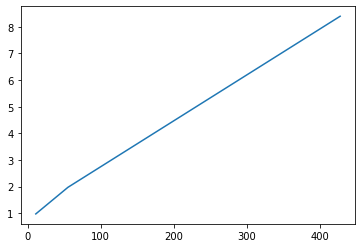

In [656]:
plt.plot([11.09,55.13,428.09], [0.97,1.97,8.4])

In [662]:
np.log(25000)

10.126631103850338

In [649]:
55.13/1.97=27.98

27.984771573604064

In [652]:
11.09/0.97=11.43

11.43298969072165

In [655]:
428.09/8.4=50.96 #25000 data points
55.13/1.97=27.98 #2500 data points
11.09/0.97=11.43 #250 data points

50.963095238095235

In [ ]:
np.sum(wwt_p)

In [ ]:
np.sum(wwt_spec_Nyq)

In [ ]:
diffs=np.zeros((len(wwt_p),len(wwt_p[0])))
for i_set in range(len(wwt_p)):
    for i_val in range(len(wwt_p[0])):
        diffs[i_set,i_val]=wwt_p[i_set][i_val]-wwt_spec_Nyq[i_set][i_val]

In [612]:
diffs = np.asarray(wwt_p)- np.asarray(wwt_spec_Nyq)

In [614]:
np.max(diffs)

1.1368683772161603e-13

In [603]:
np.argmin(diffs)

3199

In [609]:
wwt_spec_Nyq

[74.70006360521062,
 74.60088977558016,
 74.00600347114195,
 73.4070297490544,
 72.80740867334393,
 72.2073266201785,
 71.60694873985388,
 71.00644044654979,
 70.40596732720068,
 69.8056949001853,
 69.2057883697007,
 68.60641237756224,
 68.007730753217,
 67.40990626279176,
 66.81310035802191,
 66.21747292593979,
 65.62318204021777,
 65.03038371508894,
 64.43923166277098,
 63.84987705533797,
 63.26246829197987,
 62.67715077259087,
 62.09406667861866,
 61.513354762089385,
 60.935150143704156,
 60.35958412087328,
 59.786783986520376,
 59.21687285944732,
 58.64996952700244,
 58.08618830074186,
 57.52563888571206,
 56.96842626391568,
 56.41465059245277,
 55.86440711674958,
 55.31778609921,
 54.774872763535136,
 54.23574725487009,
 53.70048461584717,
 53.169154778496846,
 52.64182257190996,
 52.11854774543356,
 51.599385007094746,
 51.0843840768511,
 50.57358975417807,
 50.06704199941728,
 49.56477602822778,
 49.066822418405934,
 48.57320722826851,
 48.08395212572991,
 47.59907452714907,
 47

In [585]:
np.mean(np.sum(np.asarray(wwt_p), axis=1) == np.sum(np.asarray(wwt_spec_Nyq).reshape(4000,250), axis=1))

1.0

In [607]:
wwt_spec_Nyq[3199]

3.1296670021442283

In [606]:
sum_list[3199]

2.5069930438678107

In [608]:
wwt_p[3199]

2.5069930438678107

In [586]:
sum_list=[]
for vals250 in np.asarray(wwt_spec_Nyq).reshape(4000,250):
    sum250=0
    for val250 in vals250:
        sum250+=val250
    sum_list.append(sum250)

Text(0.5, 0, 'Expected difference in dvars values')

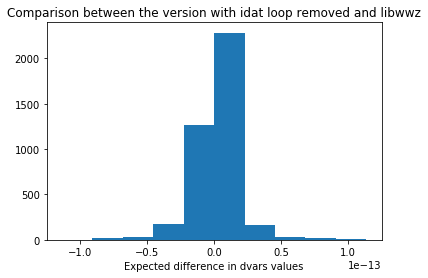

In [590]:
plt.hist(np.sum(np.asarray(wwt_p), axis=1) - sum_list)
plt.title("Comparison between the version with idat loop removed and libwwz")
plt.xlabel("Expected difference in dvars values")

In [569]:
np.sum(np.asarray(wwt_spec_Nyq).ravel()==0)

2097

In [558]:
np.max(diffs)

0.0

In [499]:
from math import fsum 
sum_p = fsum(np.asarray(wwt_p).ravel())
sum_o = 0
for values in wwt_spec_Nyq:
    sum_o += values
    
print((sum_p == sum_o),(sum_p == np.sum(wwt_spec_Nyq)))
print(())

False False
()


In [497]:
len(wwt_p.ravel())

AttributeError: 'list' object has no attribute 'ravel'

In [ ]:
np.sum(wwt_p)-np.sum(wwt_spec_Nyq)

In [566]:
np.asarray(wwt_spec_Nyq).shape

(609026,)

Text(0.5, 0, 'Difference in dweight values')

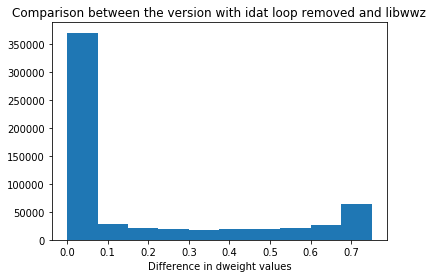

In [565]:
plt.hist(np.asarray(wwt_spec_Nyq))#,bins=500)
plt.title("Comparison between the version with idat loop removed and libwwz")
plt.xlabel("Difference in dweight values")


In [ ]:
len(wwt_p)

In [ ]:
diffs=np.zeros((len(wwt_p),len(wwt_p[0]),len(wwt_p[0][0])))
for i_set in range(len(wwt_p)):
    for i_subset in range(len(wwt_p[0])):
#         for i_val in range(len(wwt_p[0][0])):
        diffs[i_set,i_subset,:]=wwt_p[i_set][i_subset]-wwt_spec_Nyq[i_set][i_subset]#[i_val]

In [ ]:
wwt_spec_Nyq[i_set][i_subset][i_val]

In [ ]:
np.min(diffs.ravel())

In [ ]:
plt.hist(diffs.ravel(),bins=500)
# plt.title("Comparison between the version with idat loop removed and libwwz")
# plt.xlabel("Difference in dweight2 values")


In [ ]:
plt.plot(1/wwt_p[1][0], np.mean(np.abs(wwt_p[2])**2, axis=0), c="black", zorder=2)
plt.xlabel("period")
plt.ylabel("mean of squared wavelet z-transform")
plt.title("weighted wavelet z-transform")
plt.axvline(x=period, c="orange", zorder=1)
plt.show()

plt.plot(1/wwt_p[1][0], np.mean(np.abs(wwt_p[3])**2, axis=0), c="black", zorder=2)
plt.xlabel("period")
plt.ylabel("mean of squared weighted wavelet amplitude")
plt.title("weighted wavelet amplitude")
plt.axvline(x=period, c="orange", zorder=1)
plt.show()

In [ ]:
xxx=wwt_p[4]>1e-9
(~xxx).sum()
xxx= ~xxx

In [ ]:
yyy = np.ones(shape=xxx.shape)
yyy[xxx] = 0
yyy

In [ ]:
# Discrete wavelet transform (DWT)
# Lots of math here, but basically doing the summations shown in the paper
# parallelise the loop going over idat 
dz: np.ndarray = domega * (timestamps - dtau)
dweight: np.ndarray = np.exp(-1 * decay_constant * dz ** 2)
# in the loop values with weights less than 1E-9 would be
# excluded from the summation loop, so here we set them to
#zero to simulate the result of original libwwz
# if dweight > 10 ** -9
dweight_mask = dweight > 10 ** -9
dweight_mask = ~dweight_mask
dweight[dweight_mask] = 0 
cos_dz: np.ndarray = np.cos(dz)
sin_dz: np.ndarray = np.sin(dz)
# cos_dz[dweight_mask] = 0
# sin_dz[dweight_mask] = 0

dweight2 = np.sum(dweight ** 2)
dvarw = np.sum(dweight * magnitudes ** 2)
dmat[0, 0] = np.sum(dweight)
dmat[0, 1] = np.sum(dweight * cos_dz)
dmat[0, 2] = np.sum(dweight * sin_dz)
dmat[1, 1] = np.sum(dweight * cos_dz ** 2)
dmat[1, 2] = np.sum(dweight * cos_dz * sin_dz)
dmat[2, 2] = np.sum(dweight * sin_dz ** 2)

# parallel to the 3 trial functions (5-5, 6, 7)
dvec[0] = np.sum(dweight * magnitudes)
dvec[1] = np.sum(dweight * magnitudes * cos_dz)
dvec[2] = np.sum(dweight * magnitudes * sin_dz)

In [ ]:
import cython
import wwzs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import matplotlib.axes as axes
import matplotlib.colors as colors
from datetime import datetime



# generate data for a sine wave observed for 10 years with random noise added
# data = np.loadtxt(data_path+"ogle_merged/sxp327.csv", delimiter=",", dtype=float)
x = np.linspace(0, 249, num=250)
period = 3
f=1/period
y = np.sin(x*f*np.pi*2)#+np.random.normal(0,0.5,size=len(x))


# Select the size for the newly generated timestamps (tau), it should be less than the length of the given data.
# This will also limit the minimum possible frequecny
ntau = 10 #(x[-1]-x[0])/4 # no. linear divisions between first and last time stamps of the time series

# Set the low and high frequency bounds and steps to iterate 
frequency_low = 1/125
frequency_high = 1/2
# frequency_steps = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=1000)
# frequency_steps = frequency_steps[1]-frequency_steps[0]

# Set the override to False (Setting to True will ignore the low and high frequency limitations)
override = False

# gather the frequency parameters into a list [freq_low, freq_high, freq_step, override]
frequency_parameters = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=400)#[frequency_low, frequency_high, frequency_steps, override]

# We will then select the decay constant for our analyzing wavelet (should be < 0.2), where c = 1/(2*w^2) 
# The analyzing wavelet decays significantly in a single cycle 2*pi/w, where w = 2*pi*f

# f = 20     # we choose 4 since our signal of interest is at 4 h
# w = 2 * np.pi * f
# decay_constant = 1/(2*w**2)
decay_constant = 1/(8*np.pi**2)
# Finally, we select to wether to run with parallization (recommend True)
parallel = True


# Using the above settings, we will now compute the WWZ/WWA for the full timeseries and removed timeseries
wwt_spec_Nyq = wwzs.wwt(timestamps=x,
                     magnitudes=y,
                     time_divisions=ntau,
                     freq_params=frequency_parameters,
                     decay_constant=decay_constant)
                        #, parallel=False)

def make_tau_plot_grid(tau_mat: np.ndarray) -> np.ndarray:
    """
    Used for both octave and linear.
    Takes the TAU output from wwz.py and creates a grid for pcolormesh
    :param tau_mat: TAU output from wwz.py
    :return:
    """

    # Get the tau values from tau_mat
    taus = tau_mat[:, 0]

    # Append one tau value for edge limit by adding the step to the largest tau
    taus = np.append(taus, taus[-1] + taus[1] - taus[0])

    # Tile the taus with an additional column to create grid that matches freq_grid
    tau_grid = np.tile(taus, (tau_mat.shape[1] + 1, 1)).transpose()

    return tau_grid


def make_linear_freq_plot_grid(freq_mat: np.ndarray) -> np.ndarray:
    """
    Used for linear method.
    Takes the FREQ output from wwz.py and creates a grid for pcolormesh.
    :param freq_mat: FREQ output from wwz.py
    :return: freq_grid: np.ndarray with the boundaries for the FREQ output
    """

    # Get the array of center frequencies from the freq_mat
    freq_centers = freq_mat[0, :]

    # Get the freq_steps by subtracting the first two freq_centers
    freq_step = freq_centers[1] - freq_centers[0]

    # Subtract half of the freq_step from the freq_centers to get lower bound
    freq_lows = freq_centers - freq_step / 2

    # Append the high frequency bound to get all the boundaries
    freq_highest = freq_centers.max() + freq_step / 2
    freq_bounds = np.append(freq_lows, freq_highest)

    # Tile the freq_bounds to create a grid
    freq_grid = np.tile(freq_bounds, (freq_mat.shape[0] + 1, 1))

    return freq_grid


def linear_plotter_log_1(ax: axes, TAU: np.ndarray, FREQ: np.ndarray, DATA: np.ndarray, clip=None):
    """
    Creates a plot for the 'linear' method.
    You can add titles after calling the plotter.
    :param ax: axis from a matplotlib.pyplot.subplots() to plot the data
    :param TAU: TAU output of the wwz.py (the time shifts)
    :param FREQ: FREQ output of the wwz.py (the frequencies)
    :param DATA: Desired data to be plotted
    :return:
    """
    #mask zero values, required to allow log scale axis
    DATA_masked = np.ma.masked_where(DATA == 0., DATA)
    data_mean = DATA_masked.mean()
    data_std = DATA_masked.std()
    if clip:
        DATA_clipped = np.clip(DATA_masked, clip[0], clip[1])
    else:
        DATA_clipped = DATA_masked

    # Create grid for pcolormesh boundaries
    tau_grid = make_tau_plot_grid(TAU)
    freq_grid = make_linear_freq_plot_grid(FREQ)

    # Plot using subplots
    im = ax.pcolormesh(tau_grid, freq_grid, DATA_clipped, norm=colors.LogNorm(vmin=DATA_clipped.min(), vmax=DATA_clipped.max()))
    
    # Add color bar and fix y_ticks
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.1)
    ax.set_yticks(FREQ[0, :])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    cbar.ax.set_ylabel('wavelet power (z-statistic)', rotation=90)




fig, ax = plt.subplots(nrows=1, sharex=False, figsize=[13, 10])
linear_plotter_log_1(ax=ax,
                       TAU=wwt_spec_Nyq[0],
                       FREQ=wwt_spec_Nyq[1],
                       DATA=wwt_spec_Nyq[2],
                    clip=(np.percentile(wwt_spec_Nyq[2], 75),np.percentile(wwt_spec_Nyq[2], 99.9)))
plt.locator_params(axis='y', nbins=100)
# ax.set_ylabel('Frequency (1/day)')
ax.set_yscale('log')
def forward(x):
    return 1 / x
def inverse(x):
    return 1 / x
secax = ax.secondary_yaxis('right')#, functions=(forward, inverse))
secax.set_ylabel('frequency ($days^{-1}$)', labelpad=0)
ax.tick_params(axis='y', which='minor')
# ax.yaxis.set_minor_formatter(ticker.LogFormatterMathtext(labelOnlyBase=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: 1/y))
ax.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: np.round(1/y, decimals=2)))
ax.set_ylabel('period (days)')
ax.set_xlabel('Date (JD)')
plt.tight_layout()

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
plt.savefig('test_images/test_spectrogram_{}.png'.format(dt_string))
plt.show()

print("done")


In [ ]:
np.where(wwt_spec_Nyq[2]==0.)

In [ ]:
from typing import List

# noinspection Mypy
import numpy as np
# noinspection Mypy
from joblib import Parallel, delayed
import multiprocessing
import time
%load_ext autoreload
%autoreload 2


def wwt(timestamps: np.ndarray,
        magnitudes: np.ndarray,
        time_divisions: int,
        freq_params: list,
        decay_constant: float,
        method: str = 'linear',
        parallel: bool = True) -> np.ndarray:
    """
    The code is based on G. Foster's FORTRAN
    code as well as eaydin's python 2.7 code. The code is updated to use numpy methods and allow for float value tau.
    It returns an array with matrix of new evenly spaced timestamps, frequencies, wwz-power, amplitude, coefficients,
    and effective number. Specific equations can be found on Grant Foster's "WAVELETS FOR PERIOD ANALYSIS OF UNEVENLY
    SAMPLED TIME SERIES". Some of the equations are labeled in the code with corresponding numbers.

    :param timestamps: An array with corresponding times for the magnitude (payload).
    :param magnitudes: An array with payload values
    :param time_divisions: number of divisions for the new timestamps
    :param freq_params: A list containing parameters for making frequency bands to analyze over with given 'method'
            'linear' -> [freq_low, freq_high, freq_step, override]
            'octave' -> [freq_tg, freq_low, freq_high, band_order, log_scale_base, override]
    :param decay_constant: decay constant for the Morlet wavelet (should be <0.02) eq. 1-2
            c = 1/(2w), the wavelet decays significantly after a single cycle of 2 * pi / w
    :param method: determines method of creating freq ('linear', 'octave') default 'linear'
    :param parallel: boolean indicate to use parallel processing or not
    :return: Tau, Freq, WWZ, AMP, COEF, NEFF in a numpy array
    """

    # Starting Weighted Wavelet Z-transform and start timer...
    print("*** Starting Weighted Wavelet Z-transform ***\n")
    process_starttime: float = time.time()

    # Get taus to compute WWZ (referred in paper as "time shift(s)")
    tau: np.ndarray = np.linspace(timestamps[0], timestamps[-1], time_divisions)
#     tau: np.ndarray = make_tau(timestamps, time_divisions) # pull this outside of the function
    ntau: int = len(tau)

    # Frequencies to compute WWZ
    freq = freq_params
#     freq: np.ndarray = make_freq(freq_low=freq_params[0],  # pull this outside of the function
#                                  freq_high=freq_params[1],
#                                  freq_steps=freq_params[2])
    nfreq: int = len(freq)

    # Get number of data from timestamps
    numdat: int = len(timestamps)

    # Get number of CPU cores on current device (used for parallel)
    num_cores = multiprocessing.cpu_count()
    
    
#     output = np.empty([ntau, nfreq, 6])
#     for i, dtau in enumerate(tau):
#         output[i] = tau_loop(dtau)
    
    

    # WWT Stars Here
    def tau_loop(dtau):
        """
        Replaced the for loop of the taus ("time shifts") for parallel processing.
        Comments include connections to the formula given in the Foster96.
        :param dtau: one of the taus being iterated
        :return: a single entry of Tau, Freq, WWZ, AMP, COEF, NEFF corresponding to dtau
        """
        # Initialize the outputs for each iteration
        index: int = 0
        output: np.ndarray = np.empty((len(freq), 6))
        nstart: int = 1
        dvarw: float = 0.0

        # loop over each interested "frequency" over the "time shifts"
        for dfreq in freq:
            # Initialize a vector (3) and matrix (3,3) and dweight2 (sum of dweight**2)
            dvec: np.ndarray = np.zeros(3)
            dmat: np.ndarray = np.zeros([3, 3])
            dweight2: float = 0.0
            # Get Scale Factor (referred in paper as "frequency")
            domega: float = 2.0 * np.pi * dfreq
            
            # Discrete wavelet transform (DWT)
            # Lots of math here, but basically doing the summations shown in the paper
            # parallelise the loop going over idat 
            dz: np.ndarray = domega * (timestamps - dtau)
            dweight: np.ndarray = np.exp(-1 * decay_constant * dz ** 2)
#             dweight_mask = dweight > 10 ** -9
#             dweight = np.take(dweight, dweight_mask)
            # if dweight > 10 ** -9
            cos_dz: np.ndarray = np.cos(dz)
            sin_dz: np.ndarray = np.sin(dz)
#             cos_dz = np.take(cos_dz, dweight_mask)
#             sin_dz = np.take(sin_dz, dweight_mask)
                
#             magnitudes_masked = np.take(magnitudes ,dweight_mask)
#             print(dweight_mask.sum())
            dweight2 = np.sum(dweight ** 2)
            dvarw = np.sum(dweight * magnitudes ** 2)
            dmat[0, 0] = np.sum(dweight)
            dmat[0, 1] = np.sum(dweight * cos_dz)
            dmat[0, 2] = np.sum(dweight * sin_dz)
            dmat[1, 1] = np.sum(dweight * cos_dz ** 2)
            dmat[1, 2] = np.sum(dweight * cos_dz * sin_dz)
            dmat[2, 2] = np.sum(dweight * sin_dz ** 2)
            
            # parallel to the 3 trial functions (5-5, 6, 7)
            dvec[0] = np.sum(dweight * magnitudes)
            dvec[1] = np.sum(dweight * magnitudes * cos_dz)
            dvec[2] = np.sum(dweight * magnitudes * sin_dz)

            # Get dneff ("effective number" for weighted projection)
            if dweight2 > 0:
                # This is equation 5-4 in the paper
                dneff: float = (dmat[0, 0] ** 2) / dweight2
            else:
                dneff = 0.0

            # Get damp, dpower, dpowz
            dcoef: List[int] = [0, 0, 0]

            if dneff > 3:
                dvec = dvec / dmat[0, 0]
                # avoid for loops
                dmat[..., 1:] /= dmat[0, 0]

                if dmat[0, 0] > 0.005:
                    dvarw = dvarw / dmat[0, 0]
                else:
                    dvarw = 0.0

                # some initialize
                dmat[0, 0] = 1.0
                davew: float = dvec[0]
                dvarw = dvarw - (davew ** 2)  # "weighted variation" eq. 5-9

                if dvarw <= 0.0:
                    dvarw = 10 ** -12

                # avoid for loops
                dmat[1, 0] = dmat[0, 1]
                dmat[2, 0] = dmat[0, 2]
                dmat[2, 1] = dmat[1, 2]

                if np.linalg.det(dmat) == 0:
                    dmat = np.linalg.pinv(dmat)
#                     print("determinant is zero, using pseudo-inverse.")
                else:
                    dmat = np.linalg.inv(dmat)

                # set dcoef and dpower
                dcoef = dmat.dot(dvec)  # y1, y2, and y3 from eq. 4-4, with 5-5, 6, 7
                dpower = np.dot(dcoef, dvec) - (davew ** 2)  # weighted model function eq. 5-10

                dpowz: float = (dneff - 3.0) * dpower / (2.0 * (dvarw - dpower))  # WWZ eq. 5-12
                damp = np.sqrt(dcoef[1] ** 2 + dcoef[2] ** 2)  # WWA eq. 5-14
            else:
                dpowz = 0.0
                damp = 0.0

            if dneff < (10 ** (-9)):
                dneff = 0.0

            if damp < (10 ** (-9)):
                damp = 0.0

            if dpowz < (10 ** (-9)):
                dpowz = 0.0

            # Let's write everything out.
            output[index] = [dtau, dfreq, dpowz, damp, dcoef[0], dneff]

            index = index + 1

        return output

    # Check if parallel or not
    if parallel:
        output = np.array(Parallel(n_jobs=num_cores)(delayed(tau_loop)(dtau) for dtau in tau))
    else:
        output = np.empty([ntau, nfreq, 6])
        for i, dtau in enumerate(tau):
            output[i] = tau_loop(dtau)

    # Format the output to be in len(tau) by len(freq) matrix for each value with correct labels

    tau_mat: np.ndarray = output[:, :, 0].reshape([ntau, nfreq])
    freq_mat: np.ndarray = output[:, :, 1].reshape([ntau, nfreq])
    wwz_mat: np.ndarray = output[:, :, 2].reshape([ntau, nfreq])
    amp_mat: np.ndarray = output[:, :, 3].reshape([ntau, nfreq])
    dcoef_mat: np.ndarray = output[:, :, 4].reshape([ntau, nfreq])
    dneff_mat: np.ndarray = output[:, :, 5].reshape([ntau, nfreq])

    output = np.array([tau_mat, freq_mat, wwz_mat, amp_mat, dcoef_mat, dneff_mat])

    # Finished Weighted Wavelet Z-transform and finish timer...
    print(round(time.time() - process_starttime, 2), 'seconds has passed to complete Weighted Wavelet Z-transform \n')

    return output

In [ ]:
def make_tau(timestamps: np.ndarray,
             time_divisions: int) -> np.ndarray:
    """
    Creates an array of times with given timestamps and time divisions to iterate over in the wwt code.
    :param timestamps: An array with corresponding times for the magnitude (payload).
    :param time_divisions: number of divisions for the new timestamps
    :return: tau
    """

    # Check to see if time_divisions is smaller than timestamps (replace if larger)
    if time_divisions > len(timestamps):
        time_divisions = len(timestamps)
        print('adjusted time_divisions to: ', time_divisions)

    # Make tau
    tau: np.ndarray = np.linspace(timestamps[0], timestamps[-1], time_divisions)

    return tau


def make_freq(freq_low: float,
              freq_high: float,
              freq_steps: float, ) -> np.ndarray:
    """
    Creates an array of frequencies with given low, high, and steps to iterate over in the wwt code.
    :param freq_low: The low end of frequency to cast WWZ
    :param freq_high: The high end of frequency to cast WWZ
    :param freq_steps: The frequency steps for casting WWZ
    :return: freq
    """
    freq: np.ndarray = np.arange(freq_low, freq_high + freq_steps, freq_steps)

    return freq


def wwt(timestamps: np.ndarray,
        magnitudes: np.ndarray,
        time_divisions: int,
        freq_params: list,
        decay_constant: float,
        method: str = 'linear',
        parallel: bool = True) -> np.ndarray:
    """
    The code is based on G. Foster's FORTRAN
    code as well as eaydin's python 2.7 code. The code is updated to use numpy methods and allow for float value tau.
    It returns an array with matrix of new evenly spaced timestamps, frequencies, wwz-power, amplitude, coefficients,
    and effective number. Specific equations can be found on Grant Foster's "WAVELETS FOR PERIOD ANALYSIS OF UNEVENLY
    SAMPLED TIME SERIES". Some of the equations are labeled in the code with corresponding numbers.

    :param timestamps: An array with corresponding times for the magnitude (payload).
    :param magnitudes: An array with payload values
    :param time_divisions: number of divisions for the new timestamps
    :param freq_params: A list containing parameters for making frequency bands to analyze over with given 'method'
            'linear' -> [freq_low, freq_high, freq_step, override]
            'octave' -> [freq_tg, freq_low, freq_high, band_order, log_scale_base, override]
    :param decay_constant: decay constant for the Morlet wavelet (should be <0.02) eq. 1-2
            c = 1/(2w), the wavelet decays significantly after a single cycle of 2 * pi / w
    :param method: determines method of creating freq ('linear', 'octave') default 'linear'
    :param parallel: boolean indicate to use parallel processing or not
    :return: Tau, Freq, WWZ, AMP, COEF, NEFF in a numpy array
    """

    # Starting Weighted Wavelet Z-transform and start timer...
    print("*** Starting Weighted Wavelet Z-transform ***\n")
    process_starttime: float = time.time()

    # Get taus to compute WWZ (referred in paper as "time shift(s)")
    tau: np.ndarray = make_tau(timestamps, time_divisions)
    ntau: int = len(tau)

    # Calculate pseudo sample rate and largest time window to check for requirements
    freq_pseudo_sr = 1 / np.median(np.diff(timestamps))  # 1 / median period

    # noinspection PyArgumentList
    largest_tau_window = tau[1] - tau[0]
    print('Pseudo sample frequency (median) is ', np.round(freq_pseudo_sr, 3))
    print('largest tau window is ', np.round(largest_tau_window, 3))

    # Frequencies to compute WWZ
    if method == 'linear':
        freq: np.ndarray = freq_params
            #np.arange(freq_params[0], freq_params[1] + freq_params[2], freq_params[2])
            #np.ndarray = make_freq(freq_low=freq_params[0],
             #                        freq_high=freq_params[1],
              #                       freq_steps=freq_params[2])
        nfreq: int = len(freq)

    elif method == 'octave':
        freq = make_octave_freq(freq_target=freq_params[0],
                                freq_low=freq_params[1],
                                freq_high=freq_params[2],
                                band_order=freq_params[3],
                                log_scale_base=freq_params[4],
                                freq_pseudo_sr=freq_pseudo_sr,
                                largest_tau_window=largest_tau_window,
                                override=freq_params[5])
        nfreq = len(freq)

    # Get number of data from timestamps
    numdat: int = len(timestamps)

    # Get number of CPU cores on current device (used for parallel)
    num_cores = multiprocessing.cpu_count()

    # WWT Stars Here
    def tau_loop(dtau):
        """
        Replaced the for loop of the taus ("time shifts") for parallel processing.
        Comments include connections to the formula given in the Foster96.
        :param dtau: one of the taus being iterated
        :return: a single entry of Tau, Freq, WWZ, AMP, COEF, NEFF corresponding to dtau
        """
        # Initialize the outputs for each iteration
        index: int = 0
        output: np.ndarray = np.empty((len(freq), 6))
        nstart: int = 1
        dvarw: float = 0.0

        # loop over each interested "frequency" over the "time shifts"
        for dfreq in freq:
            # Initialize a vector (3) and matrix (3,3) and dweight2 (sum of dweight**2)
            dvec: np.ndarray = np.zeros(3)
            dmat: np.ndarray = np.zeros([3, 3])
            dweight2: float = 0.0
            # Get Scale Factor (referred in paper as "frequency")
            domega: float = 2.0 * np.pi * dfreq

            # Discrete wavelet transform (DWT)
            # Lots of math here, but basically doing the summations shown in the paper
            for idat in range(nstart, numdat):
                # Get dweight (an element of "local data number" viewed as "weights" in the paper)
                dz: float = domega * (timestamps[idat] - dtau)
                dweight: float = np.exp(-1 * decay_constant * dz ** 2)

                # get upper triangular matrix of the weights and vector
                # These are used later to calculate Neff, DWT, DWP, etc in the paper
                if dweight > 10 ** -9:
                    cos_dz: float = np.cos(dz)
                    sin_dz: float = np.sin(dz)
                    dweight2 += dweight ** 2
                    dvarw += dweight * magnitudes[idat] ** 2  # Used to get "weighted variation" later

                    dmat[0, 0] += dweight
                    dmat[0, 1] += dweight * cos_dz
                    dmat[0, 2] += dweight * sin_dz
                    dmat[1, 1] += dweight * cos_dz ** 2
                    dmat[1, 2] += dweight * cos_dz * sin_dz
                    dmat[2, 2] += dweight * sin_dz ** 2

                    # parallel to the 3 trial functions (5-5, 6, 7)
                    dvec[0] += dweight * magnitudes[idat]
                    dvec[1] += dweight * magnitudes[idat] * cos_dz
                    dvec[2] += dweight * magnitudes[idat] * sin_dz

                elif dz > 0:
                    break
                else:
                    nstart = idat + 1

            # Get dneff ("effective number" for weighted projection)
            if dweight2 > 0:
                # This is equation 5-4 in the paper
                dneff: float = (dmat[0, 0] ** 2) / dweight2
            else:
                dneff = 0.0

            # Get damp, dpower, dpowz
            dcoef: List[int] = [0, 0, 0]

            if dneff > 3:
                dvec = dvec / dmat[0, 0]
                # avoid for loops
                dmat[..., 1:] /= dmat[0, 0]

                if dmat[0, 0] > 0.005:
                    dvarw = dvarw / dmat[0, 0]
                else:
                    dvarw = 0.0

                # some initialize
                dmat[0, 0] = 1.0
                davew: float = dvec[0]
                dvarw = dvarw - (davew ** 2)  # "weighted variation" eq. 5-9

                if dvarw <= 0.0:
                    dvarw = 10 ** -12

                # avoid for loops
                dmat[1, 0] = dmat[0, 1]
                dmat[2, 0] = dmat[0, 2]
                dmat[2, 1] = dmat[1, 2]

                if np.linalg.det(dmat) == 0:
                    dmat = np.linalg.pinv(dmat)
                    print("determinant is zero, using pseudo-inverse.")
                else:
                    dmat = np.linalg.inv(dmat)

                # set dcoef and dpower
                dcoef = dmat.dot(dvec)  # y1, y2, and y3 from eq. 4-4, with 5-5, 6, 7
                dpower = np.dot(dcoef, dvec) - (davew ** 2)  # weighted model function eq. 5-10

                dpowz: float = (dneff - 3.0) * dpower / (2.0 * (dvarw - dpower))  # WWZ eq. 5-12
                damp = np.sqrt(dcoef[1] ** 2 + dcoef[2] ** 2)  # WWA eq. 5-14
            else:
                dpowz = 0.0
                damp = 0.0

            if dneff < (10 ** (-9)):
                dneff = 0.0

            if damp < (10 ** (-9)):
                damp = 0.0

            if dpowz < (10 ** (-9)):
                dpowz = 0.0

            # Let's write everything out.
            output[index] = [dtau, dfreq, dpowz, damp, dcoef[0], dneff]

            index = index + 1

        return output

    # Check if parallel or not
    if parallel:
        output = np.array(Parallel(n_jobs=num_cores)(delayed(tau_loop)(dtau) for dtau in tau))
    else:
        output = np.empty([ntau, nfreq, 6])
        for i, dtau in enumerate(tau):
            output[i] = tau_loop(dtau)

    # Format the output to be in len(tau) by len(freq) matrix for each value with correct labels

    tau_mat: np.ndarray = output[:, :, 0].reshape([ntau, nfreq])
    freq_mat: np.ndarray = output[:, :, 1].reshape([ntau, nfreq])
    wwz_mat: np.ndarray = output[:, :, 2].reshape([ntau, nfreq])
    amp_mat: np.ndarray = output[:, :, 3].reshape([ntau, nfreq])
    dcoef_mat: np.ndarray = output[:, :, 4].reshape([ntau, nfreq])
    dneff_mat: np.ndarray = output[:, :, 5].reshape([ntau, nfreq])

    output = np.array([tau_mat, freq_mat, wwz_mat, amp_mat, dcoef_mat, dneff_mat])

    # Finished Weighted Wavelet Z-transform and finish timer...
    print(round(time.time() - process_starttime, 2), 'seconds has passed to complete Weighted Wavelet Z-transform \n')

    return output

In [ ]:
import cython
# import wwzp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import matplotlib.axes as axes
import matplotlib.colors as colors
from datetime import datetime



# generate data for a sine wave observed for 10 years with random noise added
# data = np.loadtxt(data_path+"ogle_merged/sxp327.csv", delimiter=",", dtype=float)
x = np.linspace(0, 249, num=250)
period = 30
f=1/period
y = np.sin(x*f*np.pi*2)#+np.random.normal(0,0.5,size=len(x))


# Select the size for the newly generated timestamps (tau), it should be less than the length of the given data.
# This will also limit the minimum possible frequecny
ntau = 10 #(x[-1]-x[0])/4 # no. linear divisions between first and last time stamps of the time series

# Set the low and high frequency bounds and steps to iterate 
frequency_low = 1/125
frequency_high = 1/2
# frequency_steps = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=1000)
# frequency_steps = frequency_steps[1]-frequency_steps[0]

# Set the override to False (Setting to True will ignore the low and high frequency limitations)
override = False

# gather the frequency parameters into a list [freq_low, freq_high, freq_step, override]
frequency_parameters = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=4000)#[frequency_low, frequency_high, frequency_steps, override]

# We will then select the decay constant for our analyzing wavelet (should be < 0.2), where c = 1/(2*w^2) 
# The analyzing wavelet decays significantly in a single cycle 2*pi/w, where w = 2*pi*f

# f = 20     # we choose 4 since our signal of interest is at 4 h
# w = 2 * np.pi * f
# decay_constant = 1/(2*w**2)
decay_constant = 1/(8*np.pi**2)
# Finally, we select to wether to run with parallization (recommend True)
parallel = True


# Using the above settings, we will now compute the WWZ/WWA for the full timeseries and removed timeseries
wwt_spec_Nyq = wwt(timestamps=x,
                     magnitudes=y,
                     time_divisions=ntau,
                     freq_params=frequency_parameters,
                     decay_constant=decay_constant, parallel=False)

def make_tau_plot_grid(tau_mat: np.ndarray) -> np.ndarray:
    """
    Used for both octave and linear.
    Takes the TAU output from wwz.py and creates a grid for pcolormesh
    :param tau_mat: TAU output from wwz.py
    :return:
    """

    # Get the tau values from tau_mat
    taus = tau_mat[:, 0]

    # Append one tau value for edge limit by adding the step to the largest tau
    taus = np.append(taus, taus[-1] + taus[1] - taus[0])

    # Tile the taus with an additional column to create grid that matches freq_grid
    tau_grid = np.tile(taus, (tau_mat.shape[1] + 1, 1)).transpose()

    return tau_grid


def make_linear_freq_plot_grid(freq_mat: np.ndarray) -> np.ndarray:
    """
    Used for linear method.
    Takes the FREQ output from wwz.py and creates a grid for pcolormesh.
    :param freq_mat: FREQ output from wwz.py
    :return: freq_grid: np.ndarray with the boundaries for the FREQ output
    """

    # Get the array of center frequencies from the freq_mat
    freq_centers = freq_mat[0, :]

    # Get the freq_steps by subtracting the first two freq_centers
    freq_step = freq_centers[1] - freq_centers[0]

    # Subtract half of the freq_step from the freq_centers to get lower bound
    freq_lows = freq_centers - freq_step / 2

    # Append the high frequency bound to get all the boundaries
    freq_highest = freq_centers.max() + freq_step / 2
    freq_bounds = np.append(freq_lows, freq_highest)

    # Tile the freq_bounds to create a grid
    freq_grid = np.tile(freq_bounds, (freq_mat.shape[0] + 1, 1))

    return freq_grid


def linear_plotter_log_1(ax: axes, TAU: np.ndarray, FREQ: np.ndarray, DATA: np.ndarray, clip=None):
    """
    Creates a plot for the 'linear' method.
    You can add titles after calling the plotter.
    :param ax: axis from a matplotlib.pyplot.subplots() to plot the data
    :param TAU: TAU output of the wwz.py (the time shifts)
    :param FREQ: FREQ output of the wwz.py (the frequencies)
    :param DATA: Desired data to be plotted
    :return:
    """
    #mask zero values, required to allow log scale axis
    DATA_masked = np.ma.masked_where(DATA == 0., DATA)
    data_mean = DATA_masked.mean()
    data_std = DATA_masked.std()
    if clip:
        DATA_clipped = np.clip(DATA_masked, clip[0], clip[1])
    else:
        DATA_clipped = DATA_masked

    # Create grid for pcolormesh boundaries
    tau_grid = make_tau_plot_grid(TAU)
    freq_grid = make_linear_freq_plot_grid(FREQ)

    # Plot using subplots
    im = ax.pcolormesh(tau_grid, freq_grid, DATA_clipped, norm=colors.LogNorm(vmin=DATA_clipped.min(), vmax=DATA_clipped.max()))
    
    # Add color bar and fix y_ticks
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.1)
    ax.set_yticks(FREQ[0, :])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    cbar.ax.set_ylabel('wavelet power (z-statistic)', rotation=90)




fig, ax = plt.subplots(nrows=1, sharex=False, figsize=[13, 10])
linear_plotter_log_1(ax=ax,
                       TAU=wwt_spec_Nyq[0],
                       FREQ=wwt_spec_Nyq[1],
                       DATA=wwt_spec_Nyq[2],
                    clip=(np.percentile(wwt_spec_Nyq[2], 75),np.percentile(wwt_spec_Nyq[2], 99.9)))
plt.locator_params(axis='y', nbins=100)
# ax.set_ylabel('Frequency (1/day)')
ax.set_yscale('log')
def forward(x):
    return 1 / x
def inverse(x):
    return 1 / x
secax = ax.secondary_yaxis('right')#, functions=(forward, inverse))
secax.set_ylabel('frequency ($days^{-1}$)', labelpad=0)
ax.tick_params(axis='y', which='minor')
# ax.yaxis.set_minor_formatter(ticker.LogFormatterMathtext(labelOnlyBase=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: 1/y))
ax.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: np.round(1/y, decimals=2)))
ax.set_ylabel('period (days)')
ax.set_xlabel('Date (JD)')
plt.tight_layout()

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
plt.savefig('test_images/test_spectrogram_{}.png'.format(dt_string))


print("done")


In [ ]:
plt.plot(1/wwt_spec_Nyq[1][0], np.sum(np.abs(wwt_spec_Nyq[2])**2, axis=0), c="black", zorder=2)
plt.xlabel("period")
plt.ylabel("wavelet power")
plt.title("weighted wavelet z-transform")
plt.axvline(x=period, c="orange", zorder=1)
plt.show()

plt.plot(1/wwt_spec_Nyq[1][0], np.sum(np.abs(wwt_spec_Nyq[3])**2, axis=0), c="black", zorder=2)
plt.xlabel("period")
plt.ylabel("wavelet power")
plt.title("weighted wavelet amplitude")
plt.axvline(x=period, c="orange", zorder=1)
plt.show()

In [ ]:
xxx = np.arange(9).reshape((3,3))
print(xxx)
xxx[..., 1:] = 9
print(xxx)

In [ ]:
[[148.96815358  -1.39760869  17.95894166]
 [  0.          74.09374335   4.34190099]
 [  0.           0.          74.87441022]] [0.24898703 0.249246   0.00197489]
[[147.77081559  -1.04510932  17.78735739]
 [  0.          73.66742537   4.31067687]
 [  0.           0.          74.10339023]] [ 0.25060292  0.25094251 -0.00307129]
[[146.57163435  -0.7149656   17.6599537 ]
 [  0.          73.22233524   4.32130049]
 [  0.           0.          73.34929911]] [ 0.25218481  0.25322755 -0.00770194]
[[145.37093571  -0.4117386   17.57215238]
 [  0.          72.74931675   4.36653313]
 [  0.           0.          72.62161897]] [ 0.25373208  0.25602774 -0.01184946]
[[ 1.44169048e+02 -1.39237711e-01  1.75188926e+01]
 [ 0.00000000e+00  7.22416215e+01  4.43712738e+00]
 [ 0.00000000e+00  0.00000000e+00  7.19274261e+01]] [ 0.25524412  0.25926154 -0.01545804]
[[1.42966300e+02 9.95328800e-02 1.74947473e+01]
 [0.00000000e+00 7.16953268e+01 4.52256401e+00]
 [0.00000000e+00 0.00000000e+00 7.12709731e+01]] [ 0.25672038  0.26284111 -0.01848467]
[[141.76302319   0.30240973  17.49404628]
 [  0.          71.10953556   4.61187317]
 [  0.           0.          70.65348762]] [ 0.25816035  0.26667431 -0.02089998]
[[140.55954917   0.4680867   17.5110034 ]
 [  0.          70.48634246   4.69447671]
 [  0.           0.          70.07320671]] [ 0.25956359  0.27066681 -0.02268872]
[[139.35620968   0.59611202  17.53984416]
 [  0.          69.83056766   4.76098464]
 [  0.           0.          69.52564202]] [ 0.2609297   0.2747243  -0.02384986]
[[138.15333631   0.68686576  17.57493137]
 [  0.          69.1492794    4.80388132]
 [  0.           0.          69.00405691]] [ 0.26225835  0.27875467 -0.02439644]
[[136.95125995   0.74151829  17.61088524]
 [  0.          68.4511451    4.81804484]
 [  0.           0.          68.50011486]] [ 0.26354924  0.28267019 -0.02435491]

In [ ]:
[[149.96815358  -0.39760869  17.95894166]
 [  0.          75.09374335   4.34190099]
 [  0.           0.          74.87441022]] [0.24898703 0.249246   0.00197489]
[[ 1.48770816e+02 -4.51093245e-02  1.77873574e+01]
 [ 0.00000000e+00  7.46674254e+01  4.31067687e+00]
 [ 0.00000000e+00  0.00000000e+00  7.41033902e+01]] [ 0.25060292  0.25094251 -0.00307129]
[[147.57163435   0.2850344   17.6599537 ]
 [  0.          74.22233524   4.32130049]
 [  0.           0.          73.34929911]] [ 0.25218481  0.25322755 -0.00770194]
[[146.37093571   0.5882614   17.57215238]
 [  0.          73.74931675   4.36653313]
 [  0.           0.          72.62161897]] [ 0.25373208  0.25602774 -0.01184946]
[[145.16904768   0.86076229  17.51889259]
 [  0.          73.24162153   4.43712738]
 [  0.           0.          71.92742614]] [ 0.25524412  0.25926154 -0.01545804]
[[143.96629988   1.09953288  17.49474727]
 [  0.          72.69532682   4.52256401]
 [  0.           0.          71.27097306]] [ 0.25672038  0.26284111 -0.01848467]
[[142.76302319   1.30240973  17.49404628]
 [  0.          72.10953556   4.61187317]
 [  0.           0.          70.65348762]] [ 0.25816035  0.26667431 -0.02089998]
[[141.55954917   1.4680867   17.5110034 ]
 [  0.          71.48634246   4.69447671]
 [  0.           0.          70.07320671]] [ 0.25956359  0.27066681 -0.02268872]
[[140.35620968   1.59611202  17.53984416]
 [  0.          70.83056766   4.76098464]
 [  0.           0.          69.52564202]] [ 0.2609297   0.2747243  -0.02384986]
[[139.15333631   1.68686576  17.57493137]
 [  0.          70.1492794    4.80388132]
 [  0.           0.          69.00405691]] [ 0.26225835  0.27875467 -0.02439644]
[[137.95125995   1.74151829  17.61088524]
 [  0.          69.4511451    4.81804484]
 [  0.           0.          68.50011486]] [ 0.26354924  0.28267019 -0.02435491]

In [ ]:
numdat = 250 #len(timestamps)
nstart = 1
list(range(nstart, numdat))

In [ ]:
[[ 3.11272526  0.50000001 -0.03404031] wwz edited
 [ 0.          2.94040937  0.4941958 ]
 [ 0.          0.          0.17231588]] [-0.31648676  1.13763231  0.14284524]
[[ 3.08578726  0.50000001 -0.02568181]
 [ 0.          2.98788639  0.38043161]
 [ 0.          0.          0.09790087]] [-0.31726051  1.13703793  0.10859059]
[[ 3.059127    0.50000001 -0.01722703]
 [ 0.          3.01556877  0.25714417]
 [ 0.          0.          0.04355823]] [-0.3180622   1.13679448  0.07353864]
[[ 3.03274162  0.50000001 -0.00866893]
 [ 0.          3.02193633  0.12879013]
 [ 0.          0.          0.01080529]] [-0.31889297  1.13669035  0.03741938]
[[ 3.00662827e+00  5.00000014e-01 -3.28260718e-17]
 [ 0.00000000e+00  3.00662827e+00  4.79522747e-16]
 [ 0.00000000e+00  0.00000000e+00  1.50379601e-31]] [-3.19753967e-01  1.13646288e+00  1.43440732e-16]

In [ ]:

[[ 3.11272526  0.50000001 -0.03404031]
 [ 0.          2.94040937  0.4941958 ]
 [ 0.          0.          0.17231588]] [-0.31648676  1.13763231  0.14284524]
[[ 3.08578726  0.50000001 -0.02568181]
 [ 0.          2.98788639  0.38043161]
 [ 0.          0.          0.09790087]] [-0.31726051  1.13703793  0.10859059]
[[ 3.059127    0.50000001 -0.01722703]
 [ 0.          3.01556877  0.25714417]
 [ 0.          0.          0.04355823]] [-0.3180622   1.13679448  0.07353864]
[[ 3.03274162  0.50000001 -0.00866893]
 [ 0.          3.02193633  0.12879013]
 [ 0.          0.          0.01080529]] [-0.31889297  1.13669035  0.03741938]
[[ 3.00662827e+00  5.00000014e-01 -3.28260718e-17]
 [ 0.00000000e+00  3.00662827e+00  4.79522747e-16]
 [ 0.00000000e+00  0.00000000e+00  1.50379601e-31]] [-3.19753967e-01  1.13646288e+00  1.43440732e-16]

In [ ]:
xxx = np.loadtxt("output1.txt")

In [ ]:
yyy = np.loadtxt("output2.txt")

In [ ]:
(xxx == yyy).sum()

In [ ]:
xxx[-1][0]

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.0
largest tau window is  27.667
0.07 seconds has passed to complete Weighted Wavelet Z-transform 



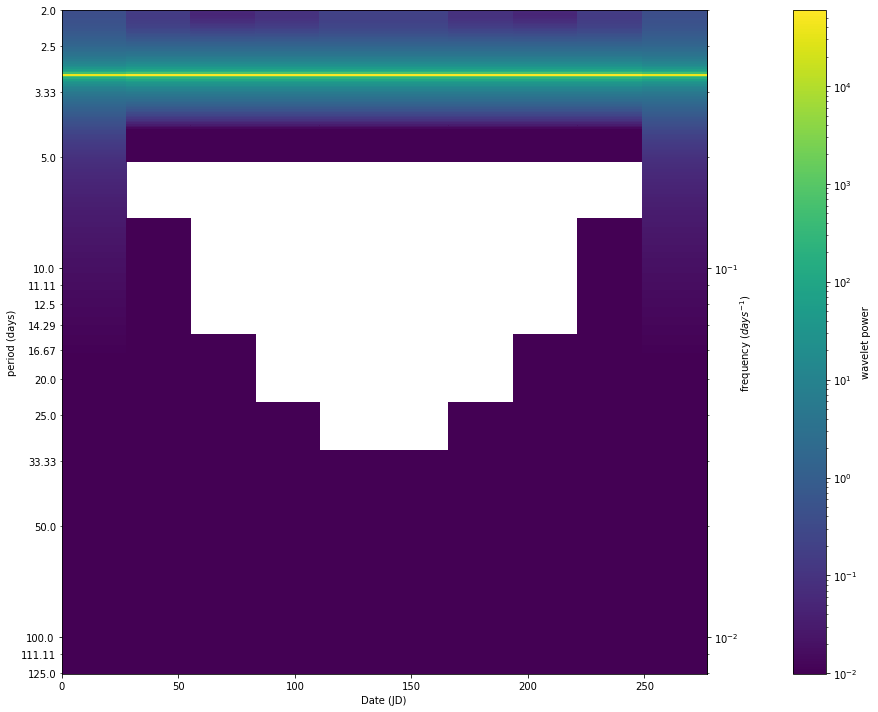

In [797]:
# generate data for a sine wave observed for 10 years with random noise added
# data = np.loadtxt(data_path+"ogle_merged/sxp327.csv", delimiter=",", dtype=float)
x = np.linspace(0, 249, num=250)
period = 3
f=1/period
y = np.sin(x*f*np.pi*2)#+np.random.normal(0,0.5,size=len(x))


# Select the size for the newly generated timestamps (tau), it should be less than the length of the given data.
# This will also limit the minimum possible frequecny
ntau = 10 #(x[-1]-x[0])/4 # no. linear divisions between first and last time stamps of the time series

# Set the low and high frequency bounds and steps to iterate 
frequency_low = 1/125
frequency_high = 1/2
# frequency_steps = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=1000)
# frequency_steps = frequency_steps[1]-frequency_steps[0]

# Set the override to False (Setting to True will ignore the low and high frequency limitations)
override = False

# gather the frequency parameters into a list [freq_low, freq_high, freq_step, override]
frequency_parameters = np.logspace(np.log10(frequency_low), np.log10(frequency_high), num=400)#[frequency_low, frequency_high, frequency_steps, override]

# We will then select the decay constant for our analyzing wavelet (should be < 0.2), where c = 1/(2*w^2) 
# The analyzing wavelet decays significantly in a single cycle 2*pi/w, where w = 2*pi*f

# f = 20     # we choose 4 since our signal of interest is at 4 h
# w = 2 * np.pi * f
# decay_constant = 1/(2*w**2)
decay_constant = 1/(8*np.pi**2)
# Finally, we select to wether to run with parallization (recommend True)
parallel = True

# Using the above settings, we will now compute the WWZ/WWA for the full timeseries and removed timeseries
wwt_p = wwzp.wwt(timestamps=x,
                     magnitudes=y,
                     time_divisions=ntau,
                     freq_params=frequency_parameters,
                     decay_constant=decay_constant, parallel=False)

fig, ax = plt.subplots(nrows=1, sharex=False, figsize=[13, 10])
plot_methods_edited.log_plotter(ax=ax,
                       TAU=wwt_p[0],
                       FREQ=wwt_p[1],
                       DATA=wwt_p[2],
                    clip=(np.percentile(wwt_p[2], 75),np.percentile(wwt_p[2], 99.9)))
fig.tight_layout()
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
# plt.savefig('test_images/test_spectrogram_{}.png'.format(dt_string))
plt.show()

In [621]:
domega = 2.0 * np.pi * frequency_parameters
                
                        
# Discrete wavelet transform (DWT)
# Lots of math here, but basically doing the summations shown in the paper
# parallelise the loop going over idat 
# dz: np.ndarray = domega * (timestamps - dtau)

In [635]:
np.array([domega,]*250).transpose()*x

array([[0.00000000e+00, 5.02654825e-02, 1.00530965e-01, ...,
        1.24155742e+01, 1.24658396e+01, 1.25161051e+01],
       [0.00000000e+00, 5.07891340e-02, 1.01578268e-01, ...,
        1.25449161e+01, 1.25957052e+01, 1.26464944e+01],
       [0.00000000e+00, 5.13182408e-02, 1.02636482e-01, ...,
        1.26756055e+01, 1.27269237e+01, 1.27782420e+01],
       ...,
       [0.00000000e+00, 3.07714505e+00, 6.15429009e+00, ...,
        7.60054826e+02, 7.63131971e+02, 7.66209116e+02],
       [0.00000000e+00, 3.10920187e+00, 6.21840374e+00, ...,
        7.67972862e+02, 7.71082064e+02, 7.74191266e+02],
       [0.00000000e+00, 3.14159265e+00, 6.28318531e+00, ...,
        7.75973385e+02, 7.79114978e+02, 7.82256571e+02]])

In [798]:
domega = 2.0 * np.pi * frequency_parameters
tau = np.linspace(0,249,10)
np.outer(domega, (x - tau))

ValueError: operands could not be broadcast together with shapes (250,) (10,) 

In [812]:
res = np.zeros((10,400,250))
for tn, tx in enumerate(tau):
    for fn, fx in enumerate(domega):
        res[tn,fn,:]=fx * (x - tx)

In [813]:
res

array([[[ 0.00000000e+00,  5.02654825e-02,  1.00530965e-01, ...,
          1.24155742e+01,  1.24658396e+01,  1.25161051e+01],
        [ 0.00000000e+00,  5.07891340e-02,  1.01578268e-01, ...,
          1.25449161e+01,  1.25957052e+01,  1.26464944e+01],
        [ 0.00000000e+00,  5.13182408e-02,  1.02636482e-01, ...,
          1.26756055e+01,  1.27269237e+01,  1.27782420e+01],
        ...,
        [ 0.00000000e+00,  3.07714505e+00,  6.15429009e+00, ...,
          7.60054826e+02,  7.63131971e+02,  7.66209116e+02],
        [ 0.00000000e+00,  3.10920187e+00,  6.21840374e+00, ...,
          7.67972862e+02,  7.71082064e+02,  7.74191266e+02],
        [ 0.00000000e+00,  3.14159265e+00,  6.28318531e+00, ...,
          7.75973385e+02,  7.79114978e+02,  7.82256571e+02]],

       [[-1.39067835e+00, -1.34041287e+00, -1.29014738e+00, ...,
          1.10248958e+01,  1.10751613e+01,  1.11254268e+01],
        [-1.40516604e+00, -1.35437691e+00, -1.30358777e+00, ...,
          1.11397501e+01,  1.11905392e

In [816]:
(x - tau[:,np.newaxis]).shape #(ntau, nfreq, timestamps)

(10, 250)

In [810]:
np.outer(domega, (x[:,np.newaxis] - tau)).shape

(400, 2500)

In [829]:
(np.ones((10,400,250)) * np.arange(250)).shape

(10, 400, 250)

In [833]:
xxx_mask = (np.ones((10,400,250)) * np.arange(250)) > 50

In [837]:
np.ones((10,400,250,3))[xxx_mask, :]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])